#Introduction
This notebook will contain the CA to simulate stock prices based on agents. It will use the model described in [1].

# The model

## Traders
The traders have three states
* Buy = 1
* Sell = -1
* Inactive = 0

## The grid
We use a 2D grid with 512x128 cells. We initialize the grid at random with a small percentage of active traders. We use the von Neumann neighbours (up,down,left, right)

## Transition
* $p_h$ : probability that an active trader can turn one of its neighbours, i.e. $\sigma_i(t) = 0 \rightarrow \sigma_i(t+1) = \pm 1$
* $p_d$ : probability that an active trader diffuses and becomes inactive $\sigma_i(t) = 1 \rightarrow \sigma_i(t+1) = 0$
* $p_e$ : the probability that an non-active cell decides to enter the market $\sigma_i(t) = 0 \rightarrow \sigma_i(t+1) = 1$

## local probability rules
probabilistic rule : 
* $\sigma_i(t+1) = 1$ with probability $p_i^k$ 
* $\sigma_i(t+1)= -1$ with probability $(1-p_i^k)$ 

where $p_i^k$ is

$$p_i^k(t) = \frac{1}{1+e^{-2I^k_i(t)}}$$
    
and $I^k_i(t)$ as

$$I^k_i(t) = \frac{1}{N^k(t)} \sum_{j=1}^{N^k(t)}A^k_{ij}\sigma^k_{j}(t)+h^k_i$$
    
with $A^k_{ij}$ as

$$ A^k_{ij} = A\xi^k(t) + \alpha\eta_{ij}(t)$$

and $h^k_i = h \zeta_i^k(t)$ with $\xi^k(t),\zeta_i^k(t),\eta_{ij}(t)$ uniform randomly between -1,1.

In [24]:
import numpy as np
from scipy.ndimage import measurements

class CAStochastic(object):
    
    def __init__(self, p, width, height, pe, pd, ph, price):
        print "Initialize model"
        self.width = width
        self.height = height
        self.initializeGrid(p, width, height)
        self.pe = pe #enter probability
        self.pd = pd #diffuse probability
        self.ph = ph #neighbor activation probability
        self.price = price # initial stock price
        
        # keep track for plotting purposes
        self.x = 0
        
        # some parameters
        self.A = 1.8
        self.a = 2*self.A
        self.h = 0
        self.beta = 0.0000001
        
        
    def getGrid(self):
        return self.grid
    
    def initializeGrid(self, p, width, height):
        print "initialize grid"
        
        # fill each sell with active buyer (state +1) with probability p
        # fill each sell with inactive trader (state 0) with probability 1-p
        self.grid = np.random.binomial(1, p, width*height).reshape(width, height)
        
    def localPRule(self, k):
        #print "Local rule"
        
        # calc local probability
        probability = 1./(1+np.exp(-2*self.localIRule(k)))
        return probability
        
    def localIRule(self,k):
        #print "Local I rule"
        
        # normalization constant
        I = 1./self.clusterSize[k-1]
        
        # sum active traders +1 and -1 states
        c = 0.0
        for i in range(int(self.nClustOnes[k-1])): # positive spins
            c += self.calcA(k)*1
        for i in range(int(self.clusterSize[k-1] - self.nClustOnes[k-1])): # negative spins
            c += self.calcA(k)*-1
            
        return I*c + self.calch() 
        
    def calcA(self, k):
        # xi is cluster dependent, pull from predefined list at beginning of timestep
        return self.A*self.xi[k-1] + self.a*self.eta()
    
    def calcXi(self,n):
        # random variable xi_k
        # calculate xi list with predefined random variable per cluster
        return np.random.uniform(-1,1,n)
    
    def eta(self):
        # random variable eta_i,j
        return np.random.uniform(-1,1)
    
    def calch(self):
        return self.h*self.zeta()
    
    def zeta(self):
        # random variable eta_k,i
        return np.random.uniform(-1,1)
        
    #http://dragly.org/2013/03/25/working-with-percolation-clusters-in-python/
    #cluster information
    def calcCluster(self):
        grid_abs = np.absolute(self.grid) # reduce field to active/inactive traders
        grid_abs = grid_abs == 1 # get field of True/False values
        
        # lw: matrix with cluster numbers, num: total number of clusters, area: matrix of cluster size 
        lw, num = measurements.label(grid_abs) 
        area = measurements.sum(grid_abs, lw, index=np.arange(1,num+1))  
    
        cluster_ones = np.zeros(num) # define empty array
        for i in range(1,num+1): # loop clusters
            cluster_ones[i-1] = (np.where(np.logical_and(lw==i,self.grid==1))[0]).size # get number of +1 states in cluster

        return lw, area, num, cluster_ones
        
    
    def doStep(self):
                
        self.nextGrid = self.grid.copy() #copy grid
        self.cluster, self.clusterSize, self.nClust, self.nClustOnes = self.calcCluster() # get cluster info
        self.xi = self.calcXi(self.nClust) #generate random numbers xi
                
        for w in range(self.width): # loop grid, update grid
            for h in range(self.height):  
                self.doCellStep(w,h)
        
        self.grid = self.nextGrid
        self.updatePrice()
        
    def doCellStep(self, i, j): # i -> width, j -> height coordinate
        cell = self.grid[i, j]
                       
        if cell == 0:
            #random enter probability
            enter = np.random.binomial(1,self.pe,1)
                        
            if enter == 1:
                self.nextGrid[i,j] = np.random.choice([1,-1], p=[0.5,0.5])
            else:
                # activate by neighbors
                # periodic boundaries
                neighbours = 0
                if abs(self.grid[i-1,j]) == 1:
                    neighbours += 1
                if abs(self.grid[i,j-1]) == 1:
                    neighbours += 1
                if abs(self.grid[(i+1)%self.width,j]) == 1:
                    neighbours += 1
                if abs(self.grid[i,(j+1)%self.height]) == 1:
                    neighbours += 1
                
                # all 1-pn, where pn is the probability that all neighbours do not activate
                # current cell, where pn= (1-ph)^N_neighbours and ph the probability of activation
                activated = np.random.binomial(1, (1-(1-self.ph)**neighbours))
                if activated == 1:
                    self.nextGrid[i,j] = np.random.choice([1,-1], p=[0.5,0.5])
            
        elif abs(cell) == 1:
            #diffuse cell
            diffuse = np.random.binomial(1,self.pd,1)
            
            if diffuse == 1 :
                self.nextGrid[i,j] = 0
            else:
                #update status cell
                k = self.cluster[i,j] #get corresponding cluster
                pk = self.localPRule(k) #calculate cell pk (flip +1/-1 probability
                #print pk
                state = np.random.choice([1,-1], 1, p=[pk,(1-pk)])
                self.nextGrid[i,j] = state
        
        
    def updatePrice(self):
        # what is beta?????
        self.x = self.beta
                
        # matrix form of summation
        vals = np.sum( np.multiply(self.clusterSize, self.nClustOnes-(self.clusterSize-self.nClustOnes) ) )

        
        # loop form
        #vals = 0
        #for i in range(len(self.clusterSize)):
        #    #sum cluster size time ones and cluster size times -1
        #    vals += self.clusterSize[i]*(self.nClustOnes[i] - (self.clusterSize[i] - self.nClustOnes[i]) )
                
        self.x *= vals
        self.price += self.price*self.x # update price
        
        if self.price < 0:
            self.price = 0 # lower bound
        
    def getPrice(self): # get current price
        return self.price
    
    def getActiveTraders(self): # get number of active traders
        return np.sum( np.absolute(self.grid))
        
        
    
    

 
        

Initialize model
initialize grid


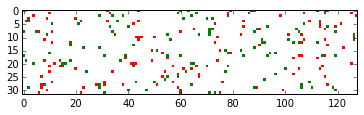

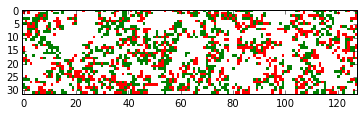

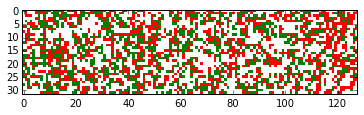

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.mlab as mlab

def CalcXcorrelation(x_list, lag): # calculate x correlations with specific lag
    return np.sum(np.multiply(x_list[lag:],x_list[:-lag]))

fig = plt.figure()

%matplotlib inline

initPrice = 100
lx, ly = 32, 128
model = CAStochastic(0.05, lx, ly, 0.0001, 0.05, 0.0485/1.5, initPrice)
steps, nView = 500, 5 # number of updates, number of viewings of the process

# keep track of lists
prices = [initPrice] # keep track of price fluctutations
activeTraders = [model.getActiveTraders()] # keep track of active traders
LogReturns = [0] # log returns
nLogReturns = [0] # normalized log returns
xs, x_correlation = [], [] # price change coefficient


for i in range(steps):
    
    model.doStep()
    
    # update lists
    prices = np.append(prices, model.getPrice())
    activeTraders = np.append(activeTraders, model.getActiveTraders())
    xs = np.append(xs, model.x)
    
    # update returns
    LogReturns = np.append(LogReturns, np.log(prices[i]) - np.log(prices[i-1]) )
    nLogReturns = np.append(nLogReturns, (LogReturns[i] - np.mean(LogReturns))/np.std(LogReturns) )
    
    
    if i % int(steps/nView) == 0: # show progress nView times
        # declare variables
        N = 10 # size
        skip = 10
        saveVideo = False
        A = model.getGrid()
        
#         print "buy/sell ratio" 
#         print np.divide(model.nClustOnes,(model.clusterSize - model.nClustOnes))
#         print "mean"
#         print np.mean(np.divide(model.nClustOnes,(model.clusterSize - model.nClustOnes)))
        

        cmap = mpl.colors.ListedColormap(['red','white','green'])
        bounds=[-1.1,-.1,.1,1.1]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        im = plt.imshow(A,interpolation='nearest',
                            cmap = cmap,norm=norm)

        plt.show()
 

print "P(t) prices"
plt.figure()
plt.plot(prices)
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)
hist, bin_edges = np.histogram(model.clusterSize)
print "cluster size distribution", hist
ax.plot(hist)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

print "fraction active traders"
plt.figure()
plt.plot(activeTraders/(1.0*lx*ly))
plt.show()

print "normalized log returns"
plt.figure()
plt.plot(nLogReturns)
plt.show()

mu, sigma = np.mean(nLogReturns), np.std(nLogReturns)
x = np.linspace(np.amin(nLogReturns),np.amax(nLogReturns),100)

print "normalized log retrun distribution"
plt.figure()
plt.hist(nLogReturns, normed=1)
plt.plot(x,mlab.normpdf(x,mu,sigma))
plt.show()

print "x distribution"
plt.figure()
plt.hist(xs)
plt.show()

for lag in range(1,50): # array of correlation
    x_correlation = np.append(x_correlation, CalcXcorrelation(xs, lag) )
x_correlation = x_correlation/x_correlation[0] # normalize to first entry

print "x correlation"
plt.figure()
plt.plot(x_correlation)
plt.show()

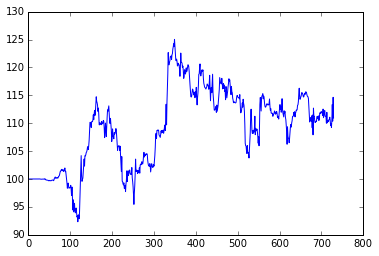

[17  0  0  0  0  0  0  0  0  1]


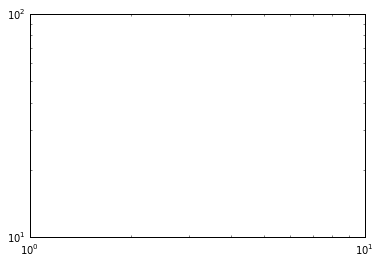

active traders


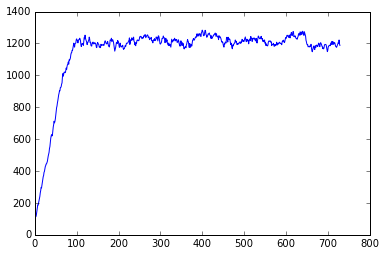

log returns


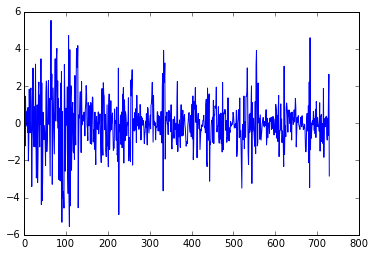

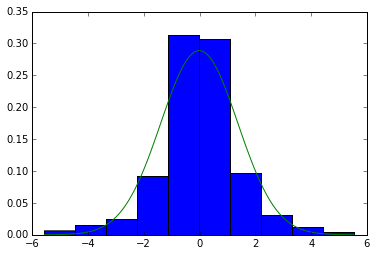

xs


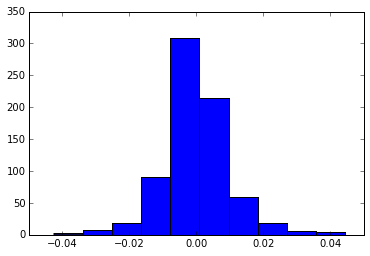

x-cor


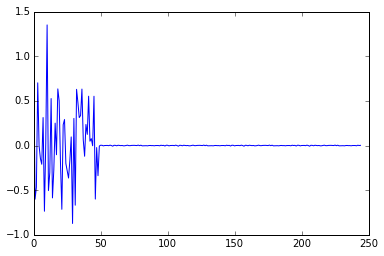

In [10]:
plt.figure()
plt.plot(prices)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
hist, bin_edges = np.histogram(model.clusterSize)
print hist
ax.scatter(np.arange(hist.size), hist)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

print "active traders"
plt.figure()
plt.plot(activeTraders)
plt.show()

print "log returns"
plt.figure()
plt.plot(nLogReturns)
plt.show()

mu, sigma = np.mean(nLogReturns), np.std(nLogReturns)
x = np.linspace(np.amin(nLogReturns),np.amax(nLogReturns),100)

plt.figure()
plt.hist(nLogReturns, normed=1)
plt.plot(x,mlab.normpdf(x,mu,sigma))
plt.show()

print "xs"
plt.figure()
plt.hist(xs)
plt.show()

for lag in range(1,50): # array of correlation
    x_correlation = np.append(x_correlation, CalcXcorrelation(xs, lag) )
x_correlation = x_correlation/x_correlation[0] # normalize to first entry

print "x-cor"
plt.figure()
plt.plot(x_correlation)
plt.show()

# Reference
[1] Bartolozzi, M., & Thomas, A. W. (2004). Stochastic cellular automata model for stock market dynamics. Physical Review E, 69(4). http://doi.org/10.1103/PhysRevE.69.046112